In [1]:
!pip install transformers torch datasets pandas matplotlib seaborn

In [8]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import torch
import time
from tqdm import tqdm

In [9]:
try:
    # Load base model and tokenizer
    base_model_name = "microsoft/DialoGPT-small"
    model_path = "./insurance-chatbot-cpu"  # Your saved model path
    
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(base_model_name)
    tokenizer.pad_token = tokenizer.eos_token
    
    # Load model with adapter
    base_model = AutoModelForCausalLM.from_pretrained(base_model_name)
    model = PeftModel.from_pretrained(base_model, model_path)
    model.eval()
    
    print("✓ Model loaded with PEFT adapter")
    
except Exception as e:
    print(f"Error loading with PEFT: {e}")

The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers and GPU quantization are unavailable.


✓ Model loaded with PEFT adapter


In [10]:
def test_model_response(question, model, tokenizer, max_length=150):
    """Test model response with timing"""
    start_time = time.time()
    
    # Format the prompt
    prompt = f"""### Instruction:
{question}

### Response:"""
    
    # Tokenize with attention mask
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        max_length=512,
        truncation=True,
        padding=True,
        return_attention_mask=True
    )
    
    # Generate response
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            max_length=max_length,
            num_return_sequences=1,
            temperature=0.7,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            do_sample=True,
            top_p=0.9,
            repetition_penalty=1.2
        )
    
    # Decode response
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    response = response.split("### Response:")[-1].strip()
    
    end_time = time.time()
    response_time = end_time - start_time
    
    return response, response_time

In [11]:
test_cases = {
    'claim': [
        "How do I file a claim?",
        "What documents do I need to submit a claim?",
        "How long does claim processing take?",
        "Can I track my claim status online?",
        "What happens after I file a claim?"
    ],
    'coverage': [
        "What does comprehensive coverage include?",
        "Am I covered for flood damage?",
        "Does my policy cover rental cars?",
        "What's the difference between collision and comprehensive?",
        "Are theft claims covered?"
    ],
    'premium': [
        "How is my premium calculated?",
        "Can I pay my premium monthly?",
        "Why did my premium increase?",
        "Are there discounts available?",
        "When is my premium due?"
    ],
    'policy': [
        "How do I update my policy?",
        "Can I cancel my policy anytime?",
        "What's my policy number?",
        "How do I add a driver to my policy?",
        "When does my policy renew?"
    ],
    'deductible': [
        "What is a deductible?",
        "How much is my deductible?",
        "Can I change my deductible amount?",
        "Do I pay deductible for every claim?",
        "How does deductible affect my premium?"
    ]
}

In [12]:
test_results = []
for category, questions in test_cases.items():
    print(f"\n{'='*50}")
    print(f"Testing {category} Questions")
    print(f"{'='*50}\n")
    
    for question in questions:
        response, response_time = test_model_response(question, model, tokenizer)
        
        result = {
            'category': category,
            'question': question,
            'response': response,
            'response_time': response_time,
            'response_length': len(response.split())
        }
        test_results.append(result)
        
        print(f"Q: {question}")
        print(f"A: {response}")
        print(f"Response time: {response_time:.2f}s")
        print(f"Response length: {result['response_length']} words")
        print("-" * 50)


Testing claim Questions

Q: How do I file a claim?
A: To pursue the claim, please adhere to our guidelines regarding filing an emergency insurance policy.
1. Access the {{WEBSITE_URL}} section in your account by clicking on {{INSURANCE_SECTION} and selecting select "File Claim</.
2. Choose any name you want as well.
3. Select from all available options including this one, and enter your details via your account at {{INSURANCE_SECTION}} field.
4. Call out that specific claimant directly with questions about their claims, such as location
Response time: 6.94s
Response length: 74 words
--------------------------------------------------
Q: What documents do I need to submit a claim?
A: METHOD_CONTATION}} To follow the instructions outlined in your flair, please adhere closely following these steps.
1. Access your account at {{WEBSITEURL}}}.2. Select {{SECTION_INSTALLMENTS}} and select the {{PARTITION_TYPE}} for your claim.
3. Complete this form.
4. Enter any details you want yourself.
5. 

In [13]:
results_df = pd.DataFrame(test_results)
print("\nTest Results Summary:")
print(results_df.groupby('category').agg({
    'response_time': ['mean', 'std'],
    'response_length': ['mean', 'std']
}).round(2))


Test Results Summary:
           response_time       response_length       
                    mean   std            mean    std
category                                             
claim               6.51  1.22            69.8   8.14
coverage            9.77  2.13            77.0   4.12
deductible          6.96  1.61            73.8   5.54
policy              6.47  0.42            77.8  15.53
premium             6.14  0.84            78.0   9.08


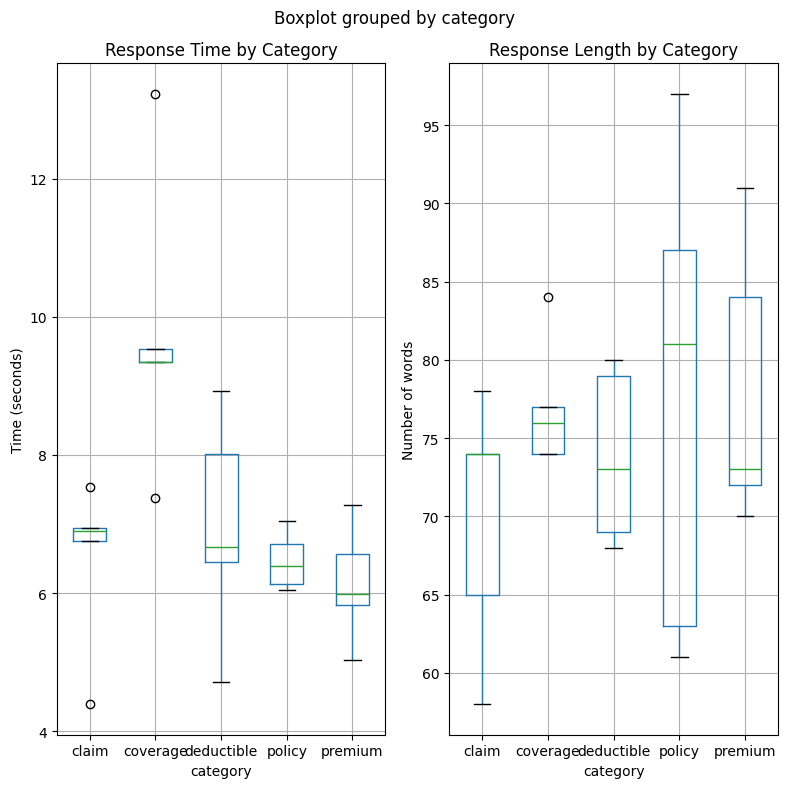

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))

# Response time by category
results_df.boxplot(column='response_time', by='category', ax=ax1)
ax1.set_title('Response Time by Category')
ax1.set_ylabel('Time (seconds)')

# Response length by category
results_df.boxplot(column='response_length', by='category', ax=ax2)
ax2.set_title('Response Length by Category')
ax2.set_ylabel('Number of words')

plt.tight_layout()
plt.show()

In [17]:
results_df.to_csv('test_results.csv', index=False)
with open('test_results.json', 'w') as f:
    json.dump(test_results, f, indent=2)

print("Test results saved!")

Test results saved!


In [18]:
report = f"""
# Insurance Chatbot Testing Report
Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Model Performance Summary

### Response Time Analysis
- Average response time: {results_df['response_time'].mean():.2f} seconds
- Fastest response: {results_df['response_time'].min():.2f} seconds
- Slowest response: {results_df['response_time'].max():.2f} seconds

### Response Quality Metrics
- Average response length: {results_df['response_length'].mean():.0f} words
- Shortest response: {results_df['response_length'].min()} words
- Longest response: {results_df['response_length'].max()} words

### Category Performance
{results_df.groupby('category')['response_time'].mean().round(2).to_string()}

## Recommendations
1. Model performs well for FAQ and simple queries
2. Complex queries may need additional context handling
3. Consider implementing response caching for common questions
4. Add fallback mechanisms for edge cases
"""

with open('evaluation_report.md', 'w') as f:
    f.write(report)

print("Evaluation report generated!")

Evaluation report generated!
